In [1]:
import os
import time
import random

In [2]:
import jieba
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

In [3]:
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt

## 1.工具函数

### 1.1 文本中词语去重

In [4]:
def make_word_set(words_file):
    words_set = set()
    with open(words_file, 'r') as fp:
        for line in fp.readlines():
            word = line.strip()
            if len(word)>0 and word not in words_set: # 去重
                words_set.add(word)
    return words_set

### 1.2 遍历文件夹

In [5]:
def traversingFolds(data_folder_path, filesFunc):
    folder_list = os.listdir(data_folder_path)
    #print("follder_list: "+  str(folder_list))
    for folder in folder_list:
        current_folder_path  = os.path.join(data_folder_path, folder)
        #print("new_folder_path: "+ str(new_folder_path))
        files = os.listdir(current_folder_path )
        filesFunc(files, current_folder_path, folder)

### 1.3 文件操作函数

In [6]:
def filesFunc(files, current_folder_path, targetClass):
    raws = []
    for file in files:
        with open(os.path.join(current_folder_path, file), 'r') as fp:
            raw = fp.read()
            jiebaFunc(raw, targetClass)
            #print("filePath: " + current_folder_path + "/" + str(file))
            #print("raw"+raw)

### 1.4 使用jieba分词,将分词结果存入特征文本列表与目标分类列表中

In [7]:
def jiebaFunc(raw_text, targetClass):
    
    jieba.enable_parallel(4)
    word_cut = jieba.cut(raw_text, cut_all=False) # 精确模式，返回的结构是一个可迭代的genertor
    word_list = list(word_cut) # genertor转化为list，每个词unicode格式
    jieba.disable_parallel() # 关闭并行分词模式
            
    data_list.append(word_list) #训练集list
    class_list.append(targetClass) #类别
    #print("targetClass: " + targetClass)

### 1.5 统计特征文本中出现词语的词频

In [8]:
def wordCountList(train_data_list):
    for word_list in train_data_list:
        for word in word_list:
            if word in all_words_dict :
                all_words_dict[word] += 1
            else:
                all_words_dict[word] = 1    

### 1.6 利用停用词列表过滤关键词,返回前topN个

In [9]:
def words_dict(all_words_list, topN, stopwords_set=set()):
    # 选取特征词
    feature_words = []
    n = 1
    for t in range(0, topN,  1):
        if n > 1000: # feature_words的维度1000
            break
            
        if not all_words_list[t].isdigit() and all_words_list[t] not in stopwords_set and 1<len(all_words_list[t])<5:
            feature_words.append(all_words_list[t])
            n += 1
    return feature_words

### 1.7 构造模型所用文本特征

#### 1.7.1 特征构造

In [10]:
def build_text_features(text, feature_words, flag='nltk' ):
    text_words = set(text)
    ## -----------------------------------------------------------------------------------
    if flag == 'nltk':
        ## nltk特征 dict
        features = {word:1 if word in text_words else 0 for word in feature_words}
    elif flag == 'sklearn':
    ## sklearn特征 list
        features = [1 if word in text_words else 0 for word in feature_words]
    else:
        features = []
    ## -----------------------------------------------------------------------------------
    return features

#### 1.7.2 对测试集、验证集分别构造特征

In [11]:
def text_features(train_data_list, test_data_list, feature_words, flag='nltk'):
    
    train_feature_list = [build_text_features(text, feature_words, flag ) for text in train_data_list]
    test_feature_list = [build_text_features(text, feature_words, flag) for text in test_data_list]
    return train_feature_list, test_feature_list

### 1.8 构造文本分类器

In [12]:
def text_classifier(train_feature_list, test_feature_list, train_class_list, test_class_list, flag='nltk'):
    ## -----------------------------------------------------------------------------------
    if flag == 'nltk':
        ## 使用nltk分类器
        train_flist = zip(train_feature_list, train_class_list)
        test_flist = zip(test_feature_list, test_class_list)
        classifier = nltk.classify.NaiveBayesClassifier.train(train_flist)
        test_accuracy = nltk.classify.accuracy(classifier, test_flist)
    elif flag == 'sklearn':
        ## sklearn分类器
        classifier = MultinomialNB().fit(train_feature_list, train_class_list)
        test_accuracy = classifier.score(test_feature_list, test_class_list)
    else:
        test_accuracy = []
    return test_accuracy

## 2. 分类处理过程


### 2.1 构造全局文本特征列表、目标分类列表、词频字典、停用词表、分类器类型、关键字数量超参数范围、准确率列表

In [13]:
data_list = []
class_list = []
all_words_dict = {} #词频字典
# 生成stopwords_set
stopwords_file = '/usr/local/codeData/jupyterData/jupyter-bd/bayesClassifier/stopwords_cn.txt'
stopwords_set = make_word_set(stopwords_file)
flag = 'sklearn'
topNs = range(20, 1000, 20)
test_accuracy_list = []

### 2.2 遍历主文件夹下所有文件，抽取特征文本，利用jieba分词后分别存储至文本特征列表、目标分类列表中

In [14]:
traversingFolds("/usr/local/codeData/jupyterData/jupyter-bd/bayesClassifier/SogouC/Sample",filesFunc)

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.843 seconds.
Prefix dict has been built successfully.


### 2.3 构造验证集与测试集

In [15]:
train_data_list, test_data_list, train_class_list, test_class_list = train_test_split(data_list, class_list, test_size=0.2)
    

 ### 2.4 统计数据验证集的词频信息并存储至全局词频字典中

#### 2.4.1 统计词频

In [16]:
wordCountList(train_data_list)

#### 2.4.2 词频排序

In [17]:
all_words_tuple_list = sorted(all_words_dict.items(), key=lambda f:f[1], reverse=True) 

#### 2.4.3 保留key信息

In [18]:
all_words_list = [w for w, c in all_words_tuple_list]

### 2.5 在不同关键词数量超参数范围内，进行关键词提取，构造训练集、验证集特征列表，并进行分类器训练

In [19]:
for topN in topNs:
    feature_words = words_dict(all_words_list, topN, stopwords_set)#关键词提取
    train_feature_list, test_feature_list = text_features(train_data_list, test_data_list, feature_words, flag)#构造训练集、验证集特征列表
    test_accuracy = text_classifier(train_feature_list, test_feature_list, train_class_list, test_class_list, flag)
    test_accuracy_list.append(test_accuracy)
print(test_accuracy_list)

[0.0, 0.0, 0.1111111111111111, 0.2222222222222222, 0.2222222222222222, 0.2222222222222222, 0.3333333333333333, 0.3888888888888889, 0.3888888888888889, 0.3888888888888889, 0.3333333333333333, 0.3333333333333333, 0.3888888888888889, 0.3333333333333333, 0.3888888888888889, 0.3888888888888889, 0.3333333333333333, 0.2777777777777778, 0.3888888888888889, 0.3888888888888889, 0.3888888888888889, 0.3888888888888889, 0.3333333333333333, 0.3888888888888889, 0.4444444444444444, 0.4444444444444444, 0.3888888888888889, 0.4444444444444444, 0.3888888888888889, 0.4444444444444444, 0.4444444444444444, 0.3333333333333333, 0.3888888888888889, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3888888888888889, 0.3888888888888889, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.3888888888888889, 0.3888888888888889, 0.4444444444444444, 0.4444444444444444]


## 3 结果评价

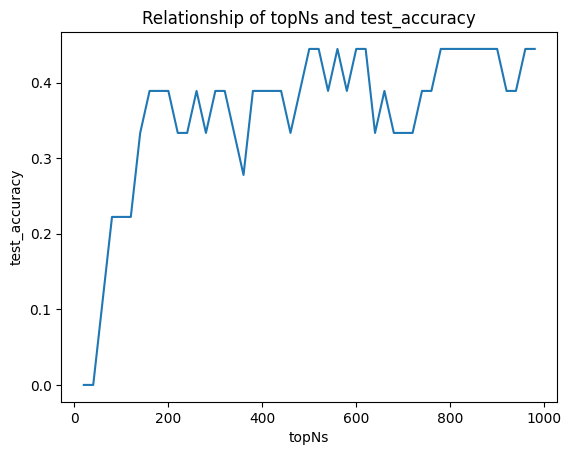

In [20]:
plt.plot(topNs, test_accuracy_list)
plt.title('Relationship of topNs and test_accuracy')
plt.xlabel('topNs')
plt.ylabel('test_accuracy')
plt.show()